In [1]:
import sys
sys.path.insert(0, "..")
from pathlib import Path
import re
import json
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.cm as cm
from packaging import version

BENCHMARK = 'pmem2bench'

def pretty_fmt(num, suffix="B"):
    for unit in ["", "K", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < 1024.0:
            return f"{num:3.0f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

FIG_DIR = Path(f'../fig/{BENCHMARK}').resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)
def save(fig, name):
    for ext in ('png', 'eps'):
        fig.savefig(FIG_DIR / f'{name}.{ext}', bbox_inches = 'tight')
    pass 

In [2]:
RAW_BASEDIR=Path("../raw/")

default_params = {
    "noflush": False,
}

job_group = (
    ("pegasus/pmem2bench/2023.06.22-18.16.11", {"platform": "pegasus", "loadApi": "libc"}),
    ("pegasus/pmem2bench/2023.06.22-19.16.25", {"platform": "pegasus", "loadApi": "libc"}),
    ("pegasus/pmem2bench/2023.06.23-12.22.20", {"platform": "pegasus", "loadApi": "libc"}),
    # ("cygnus/pmem2bench/2023.06.23-14.34.22", {"platform": "cygnus", "loadApi": "libc"}),
    ("chris90/pmem2bench/2023.06.23-18.02.15", {"platform": "chris90", "loadApi": "libc"}),
    ("chris80/pmem2bench/2023.06.30-15.23.45", {"platform": "chris80", "loadApi": "libc"}),
    ("chris90/pmem2bench/2023.07.02-13.56.01", {"platform": "chris90", "loadApi": "libpmem2"}),
    ("chris80/pmem2bench/2023.07.02-13.55.20", {"platform": "chris80", "loadApi": "libpmem2"}),
    ("pegasus/pmem2bench/2023.07.02-18.03.12", {"platform": "pegasus", "loadApi": "libpmem2"}),
    ("pegasus/pmem2bench/2023.07.03-10.40.39", {"platform": "pegasus", "loadApi": "libpmem2"}),
    ('chris80/pmem2bench/2023.07.03-11.08.54', {"platform": "chris80", "loadApi": "libpmem2"}),
    ('chris90/pmem2bench/2023.07.03-11.07.22', {"platform": "chris90", "loadApi": "libpmem2"}),
)

def parse_result(json_file: Path):
    with json_file.open() as f:
        return json.load(f)


re_iter = re.compile(r"_([0-9]+)\.json")
def parse_iter_from_filename(json_file: Path):
    m = re_iter.search(json_file.name)
    if m:
        return int(m.groups()[0])
    else:
        raise Exception("parse error: iteration")

failed_job_count = 0
job_params = []
job_results = []
for job_dir, meta_overwrite in job_group:
    job_dir = RAW_BASEDIR / job_dir
    for job_file in job_dir.glob("*.json"):
        try:
            parsed = parse_result(job_file)
            job_params.append({
                **default_params,
                **parsed["params"],
                "iter": parse_iter_from_filename(job_file),
                **meta_overwrite,
            })
            job_results.append(parsed["results"])
        except Exception as e:
            print(f"{job_file}: {e}")
            failed_job_count += 1
print(f"failed: {failed_job_count}")

df_params = pd.DataFrame(job_params)

df_params["device"] = np.select([
    (df_params.platform == "pegasus"),
    (df_params.platform == "chris90"),
    (df_params.platform.isin(["cygnus", "chris80"])),
], [
    "Optane 300",
    "Optane 200",
    "Optane 100",
])

df_params["api"] = np.select([
    (df_params.accessType == "write"),
    (df_params.accessType == "read") & (df_params.loadApi == "libc"),
    (df_params.accessType == "read") & (df_params.loadApi == "libpmem2"),
], [
    "libpmem2",
    "libc",
    "libpmem2",
])

# If loadApi is libc, it is not actually using a non-temporal store
df_params.loc[(df_params.api == "libc"), "nonTemporal"] = False
df_params.loc[(df_params.api == "libc"), "noflush"] = True

df_results = pd.DataFrame(job_results)
df_src = df_params.join(df_results)

failed: 0


In [3]:
# df_src.drop(["path"],axis=1).query("success == True and platform=='chris80'")

df_src.query("api == 'libc' and noflush == True")

,noflush,accessPattern,accessType,blockSize,granularity,nonTemporal,nthreads,path,set-affinity,source,...,loadApi,device,api,IOPS,MIOPS,MiB_per_sec,addr,byte_per_sec,success,time
1,True,sequential,read,128,page,False,4,/dev/dax0.0,True,anon,...,libc,Optane 300,libc,5.278782e+07,52.787820,6443.825730,22772990345216,6.756841e+09,True,5085.177870
4,True,random,read,2048,page,False,1,/dev/dax0.0,True,devdax,...,libc,Optane 300,libc,1.390240e+06,1.390240,2715.312697,21205327282176,2.847212e+09,True,3016.963759
6,True,sequential,read,65536,page,False,1,/dev/dax0.0,True,devdax,...,libc,Optane 300,libc,6.965542e+04,0.069655,4353.463716,21232170827776,4.564938e+09,True,1881.720059
8,True,sequential,read,524288,page,False,32,/dev/dax0.0,True,devdax,...,libc,Optane 300,libc,1.547155e+05,0.154716,77357.751564,20984136466432,8.111548e+10,True,3388.723104
13,True,random,read,512,page,False,8,/dev/dax0.0,True,devdax,...,libc,Optane 300,libc,3.148831e+07,31.488312,15375.152374,20383914786816,1.612202e+10,True,4262.461822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8048,True,sequential,read,524288,page,False,2,/dev/dax0.1,True,devdax,...,libc,Optane 100,libc,1.055767e+04,0.010558,5278.833889,140101833195520,5.535259e+09,True,3103.715772
8050,True,sequential,read,131072,page,False,4,/dev/dax0.1,True,devdax,...,libc,Optane 100,libc,7.451328e+04,0.074513,9314.160027,140047072362496,9.766605e+09,True,3518.084283
8052,True,random,read,1048576,page,False,2,/dev/dax0.1,True,devdax,...,libc,Optane 100,libc,5.134049e+03,0.005134,5134.048514,139662672789504,5.383440e+09,True,3191.243705
8056,True,random,read,256,page,False,2,/dev/dax0.1,True,devdax,...,libc,Optane 100,libc,1.088636e+07,10.886361,2657.803081,140111496871936,2.786909e+09,True,6164.489807


In [4]:
df = df_src

# remove fsdax && iter=1 && write
# df = df.drop(df[(df.source == "fsdax") & (df.accessType == "write") & (df.iter == 1)].index)

default_groupby = ["success", "platform", "source", "accessType", "api", "accessPattern", "nonTemporal", "noflush", "nthreads", "blockSize"]
grouper = df.drop(["path", "granularity", "set-affinity"], axis=1).groupby(default_groupby)

pd.set_option('display.max_rows', 50)
iters = grouper.size()
iters[iters < 3]


success  platform  source  accessType  api       accessPattern  nonTemporal  noflush  nthreads  blockSize
True     pegasus   anon    write       libpmem2  random         False        False    16        256          1
                                                                                                512          2
dtype: int64

In [5]:
# calc parallel performance
# pegasus devdax sequential nt-strore / load

df = grouper.max().reset_index().query("platform == 'pegasus' and source == 'devdax' and api == 'libpmem2' and accessPattern == 'sequential' and nonTemporal == True")
df["GiB/s"] = df["byte_per_sec"] / 2**30

# df_marged = df.join(df.query("nthreads==1")[["accessType", "blockSize", "GiB/s"]], how=["accessType", "BlockSize"])

df_merged = pd.merge(
    df,
    df.query("nthreads==1")[["accessType", "blockSize", "GiB/s"]].rename(columns={"GiB/s": "base"}),
    how='left', left_on=['accessType','blockSize'], right_on = ['accessType','blockSize'])

df_merged["speedup"] = df_merged["GiB/s"] / df_merged["base"]
df_merged["parallel_perf"] = df_merged["speedup"] / df_merged["nthreads"]

df_merged = df_merged[["accessType", "nthreads", "blockSize", "GiB/s", "speedup", "parallel_perf"]]

pd.set_option('display.max_rows', 250)

display(df_merged[(df_merged.blockSize == 64)])

pd.set_option('display.max_rows', 50)


,accessType,nthreads,blockSize,GiB/s,speedup,parallel_perf
0,read,1,64,0.357209,1.000000,1.000000
15,read,2,64,0.671559,1.880017,0.940009
30,read,4,64,1.369936,3.835114,0.958778
45,read,8,64,2.720137,7.614977,0.951872
60,read,16,64,4.883970,13.672591,0.854537
75,read,32,64,8.895718,24.903411,0.778232
90,read,48,64,13.584267,38.028925,0.792269
105,write,1,64,0.246692,1.000000,1.000000
120,write,2,64,0.493067,1.998720,0.999360
135,write,4,64,0.985045,3.993022,0.998256


('chris80', 'devdax', 'read', 'libc', 'random', False, True)


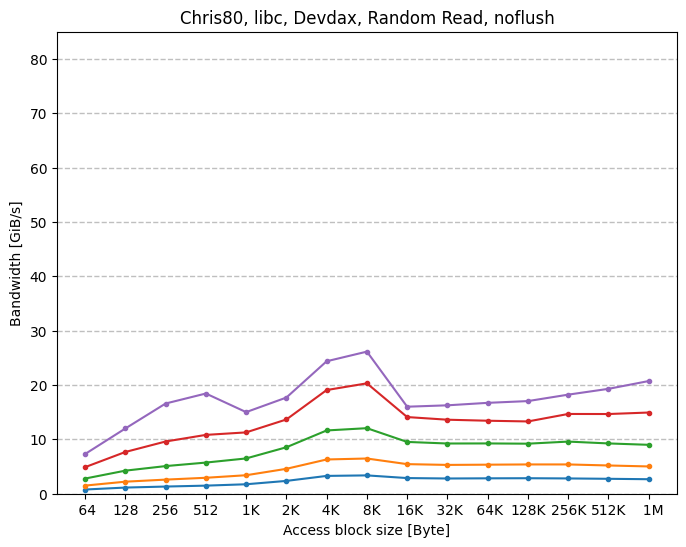

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('chris80', 'devdax', 'read', 'libc', 'sequential', False, True)


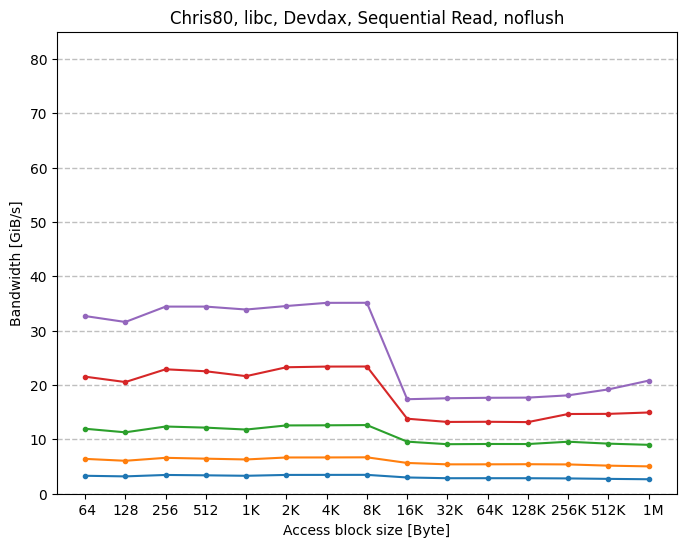

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('chris80', 'devdax', 'read', 'libpmem2', 'random', False, True)


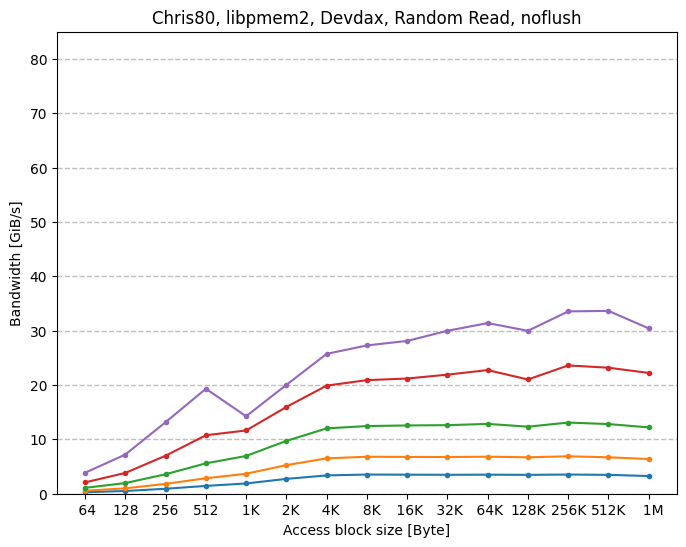

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('chris80', 'devdax', 'read', 'libpmem2', 'sequential', False, True)


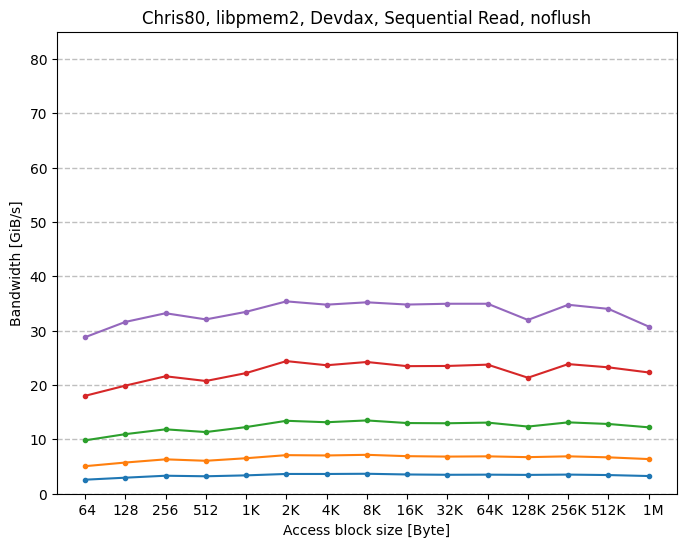

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('chris80', 'devdax', 'write', 'libpmem2', 'random', False, False)


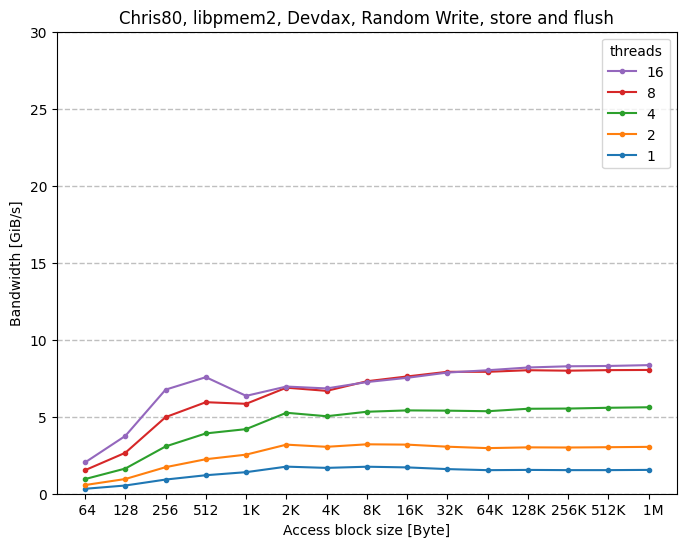

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('chris80', 'devdax', 'write', 'libpmem2', 'random', True, False)


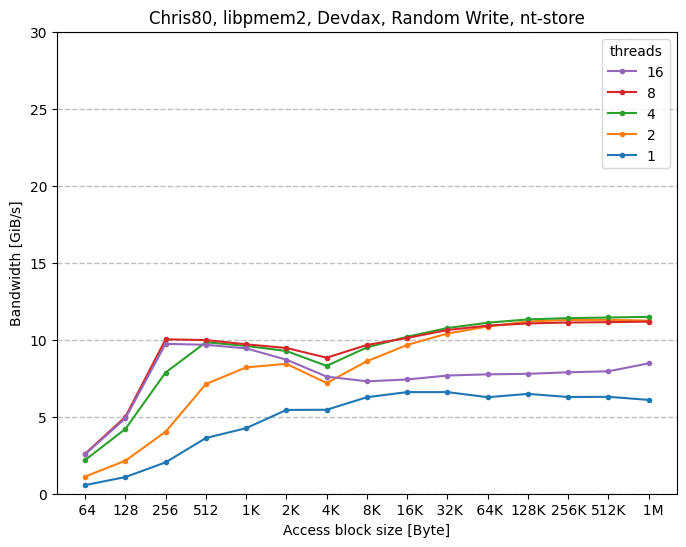

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('chris80', 'devdax', 'write', 'libpmem2', 'sequential', False, False)


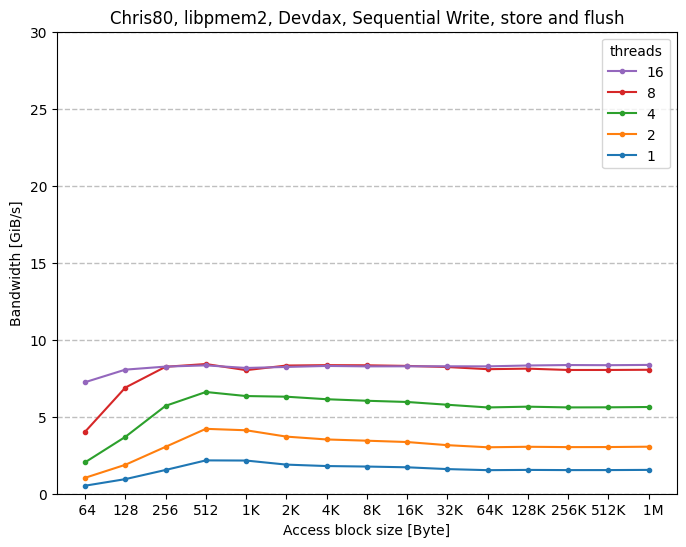

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('chris80', 'devdax', 'write', 'libpmem2', 'sequential', True, False)


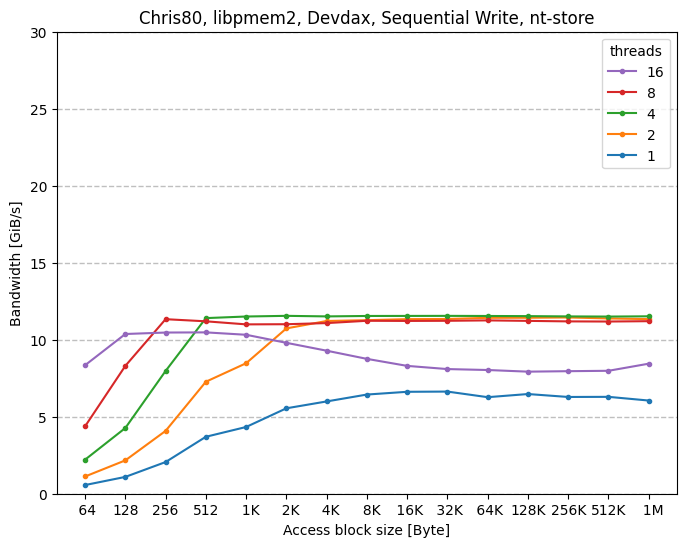

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('chris90', 'devdax', 'read', 'libc', 'random', False, True)


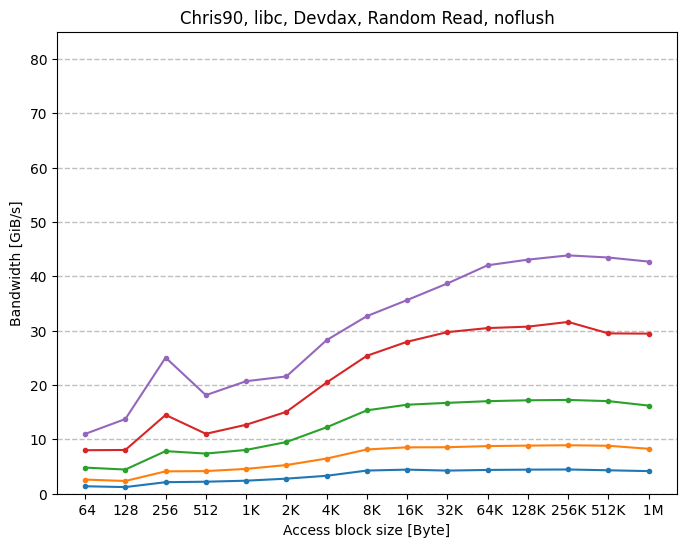

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('chris90', 'devdax', 'read', 'libc', 'sequential', False, True)


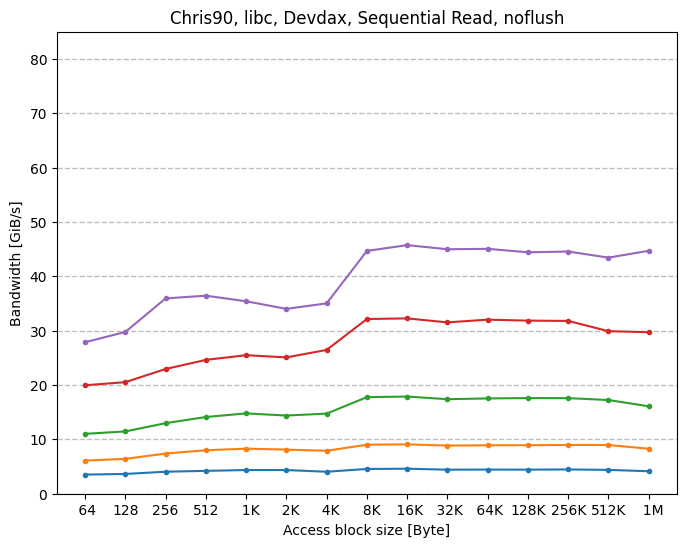

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('chris90', 'devdax', 'read', 'libpmem2', 'random', False, True)


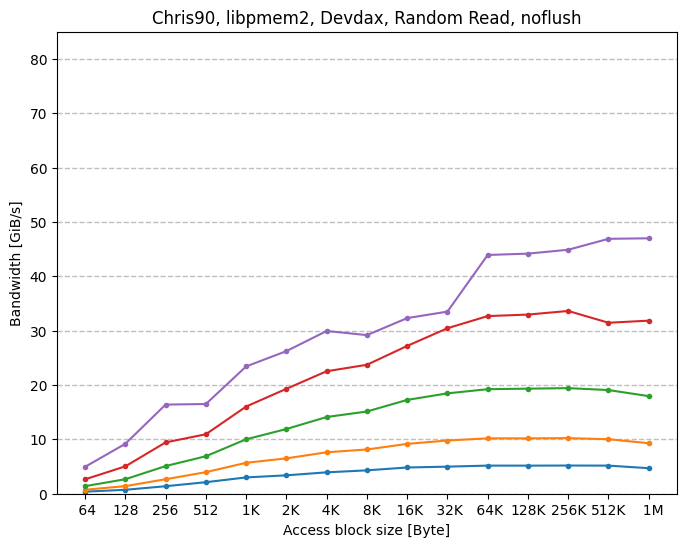

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('chris90', 'devdax', 'read', 'libpmem2', 'sequential', False, True)


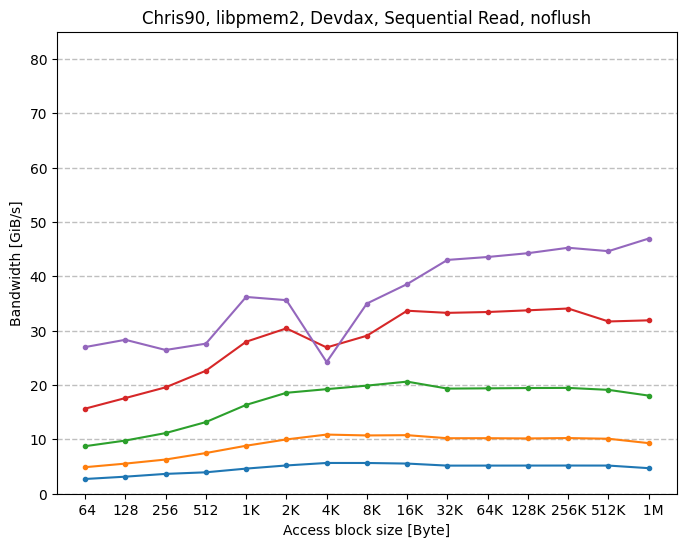

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('chris90', 'devdax', 'write', 'libpmem2', 'random', False, False)


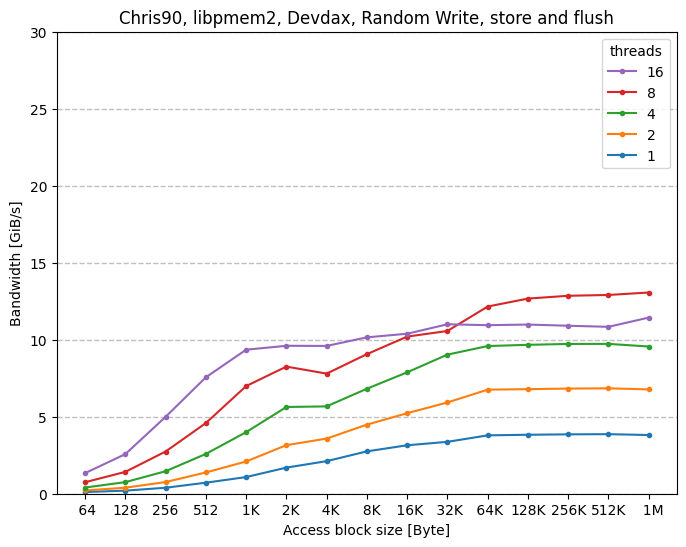

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('chris90', 'devdax', 'write', 'libpmem2', 'random', True, False)


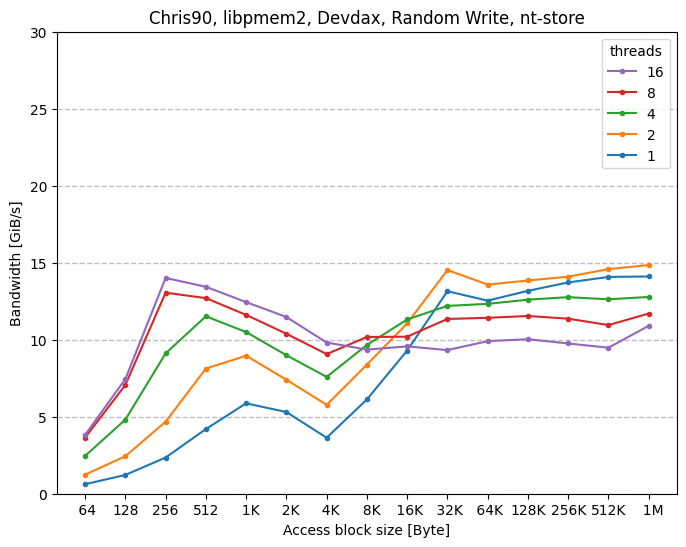

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('chris90', 'devdax', 'write', 'libpmem2', 'sequential', False, False)


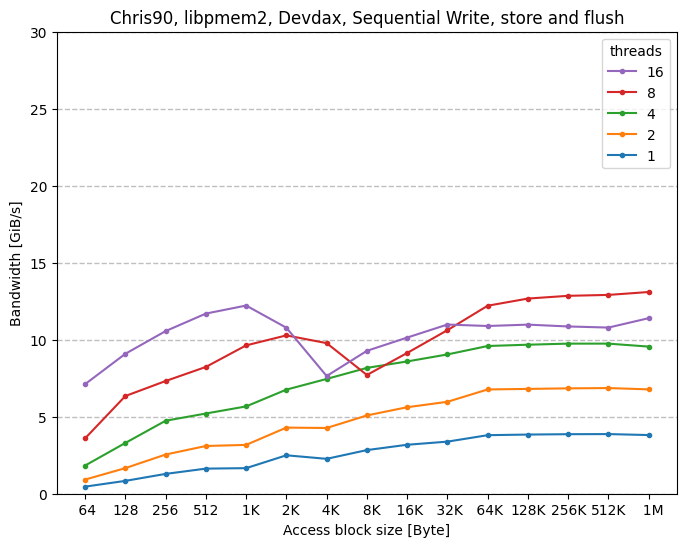

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('chris90', 'devdax', 'write', 'libpmem2', 'sequential', True, False)


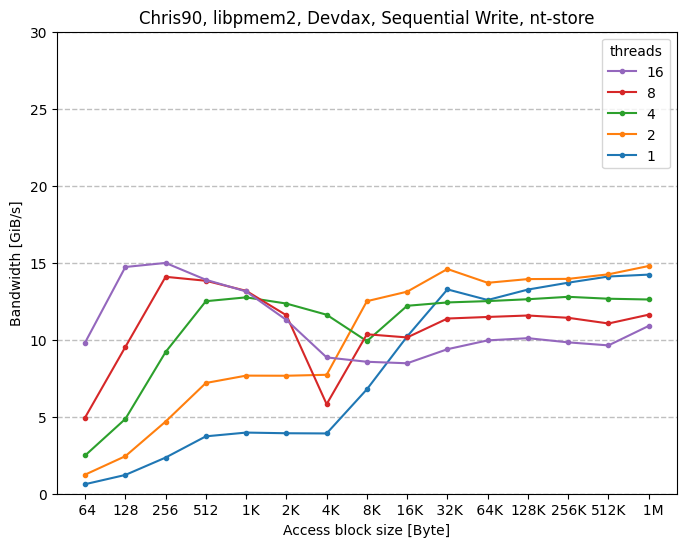

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('pegasus', 'devdax', 'read', 'libc', 'random', False, True)


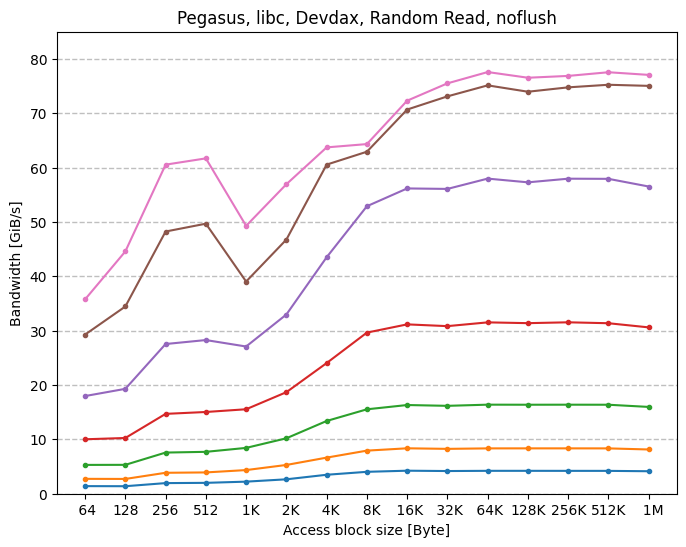

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('pegasus', 'devdax', 'read', 'libc', 'sequential', False, True)


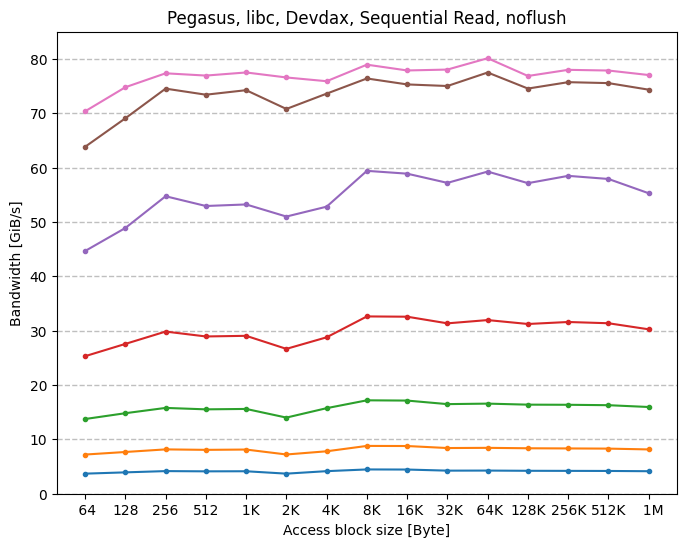

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('pegasus', 'devdax', 'read', 'libpmem2', 'random', False, True)


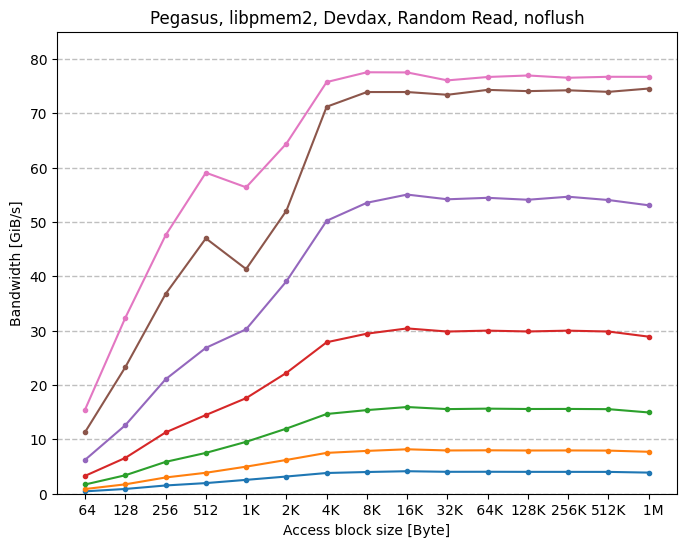

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('pegasus', 'devdax', 'read', 'libpmem2', 'sequential', False, True)


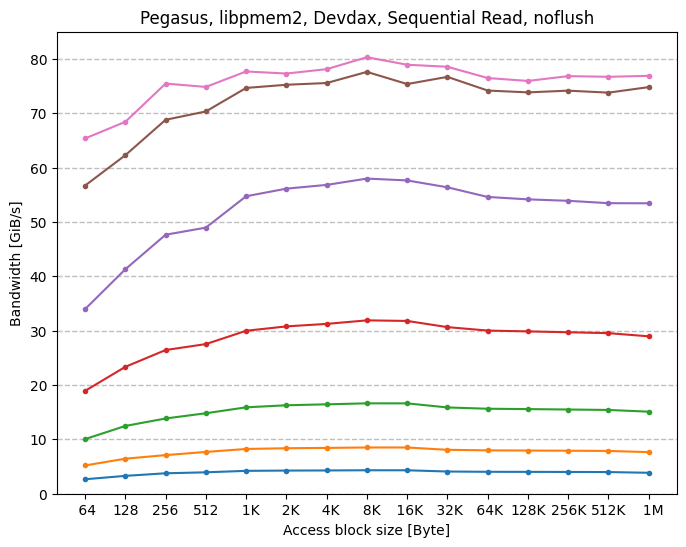

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('pegasus', 'devdax', 'write', 'libpmem2', 'random', False, False)


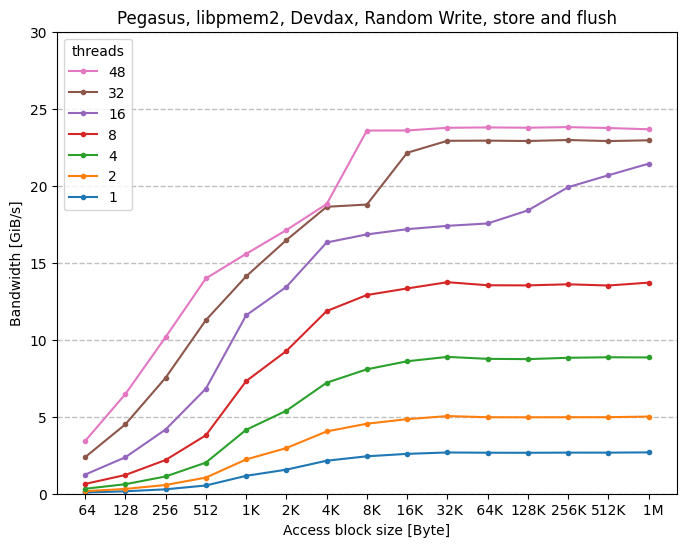

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('pegasus', 'devdax', 'write', 'libpmem2', 'random', True, False)


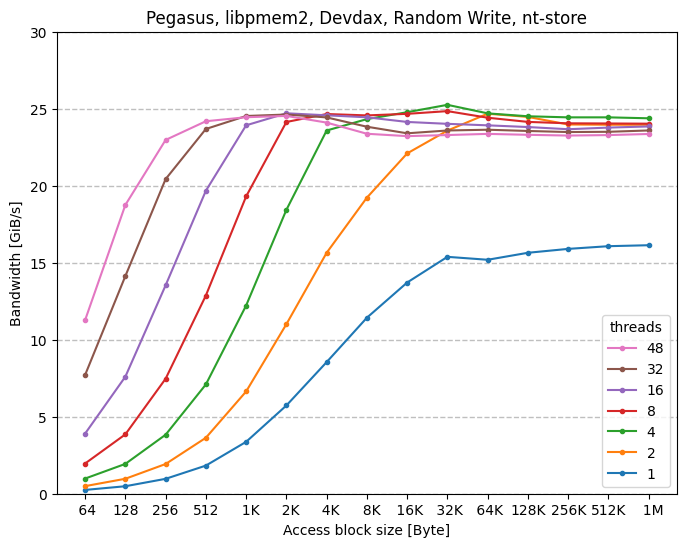

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('pegasus', 'devdax', 'write', 'libpmem2', 'sequential', False, False)


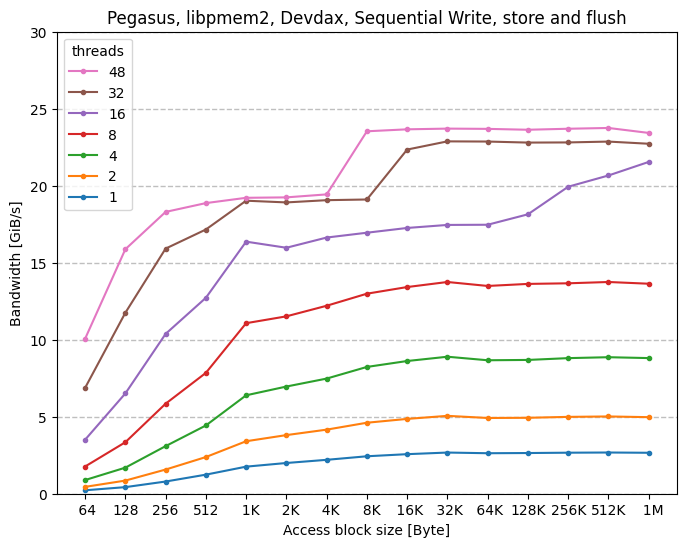

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


('pegasus', 'devdax', 'write', 'libpmem2', 'sequential', True, False)


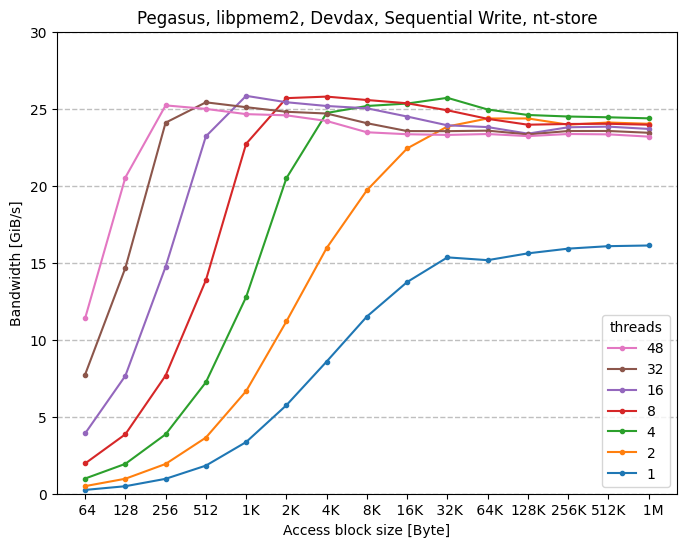

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [6]:
df = grouper.max().reset_index()

ymax = df.groupby(["accessType"]).max()["byte_per_sec"].apply(lambda x: x / 2**30).apply(lambda x: x + -x % 5).astype('int').to_dict()

for idx, df_sub in df.query("source == 'devdax' and not (accessType == 'read' and noflush == False)").groupby(["platform", "source", "accessType", "api", "accessPattern", "nonTemporal", "noflush"]):
    print(idx)
    platform, source, access_type, api, access_pattern, is_nt, is_noflush = idx
    # display(df_sub)
    df_sub["GiB/s"] = df_sub["byte_per_sec"] / 2**30
    df_plot = df_sub.pivot(index="blockSize", columns="nthreads", values="GiB/s")
    # display(df_plot)

    fig = plt.figure(figsize=(8,6), dpi=100)
    fig.patch.set_alpha(1)

    ax = df_plot.plot(
        ax=fig.add_subplot(),
        xlabel="Access block size [Byte]",
        ylabel="Bandwidth [GiB/s]",
        ylim=[0, ymax[access_type]],
        style=".-",
        legend=access_type == "write",
    )
    if is_nt:
        store_type = ", nt-store"
    elif is_noflush:
        store_type = ", noflush"
    else:
        store_type = ", store and flush"

    ax.set_title(f"{platform.capitalize()}, {api}, {source.capitalize()}, {access_pattern.capitalize()} {access_type.capitalize()}{store_type}")
    ax.set_xscale("log", base=2)
    ax.set_xticks(df_plot.index, [pretty_fmt(x, suffix="") for x in df_plot.index])
    ax.grid(which = "major", axis = "y", alpha = 0.8,
        linestyle = "--", linewidth = 1)

    if idx[2] == "write":
        handles, labels = ax.get_legend_handles_labels()# 凡例の情報を取得
        ax.legend(title='threads', handles=handles[::-1],labels=labels[::-1])# 判例を逆順に表示
        # ax.legend(handles=handles[::-1],labels=list(map(lambda x: f"{x} proc{'s' if int(x) > 1 else ''}", labels[::-1])))# 判例を逆順に表示
    
    fig.show()
    plt.show()
    ax.set_title("")
    save(fig, f"pmembench-{platform}-{api}-{source}-{access_type}-{access_pattern}{'-movnt' if is_nt else ''}{'-noflush' if is_noflush else ''}")

In [7]:
# pegasus upto 16 threads
df = df_src.query("platform == 'pegasus' and nthreads<=16").drop(["path", "granularity", "set-affinity", "addr", "success"], axis=1)

max_throuput_groupby = ["platform", "source", "accessType", "api", "accessPattern", "nonTemporal", "noflush", "blockSize"]
pegasus16_grouper = df.groupby(max_throuput_groupby)
df_pegasus16_max = df.loc[pegasus16_grouper["byte_per_sec"].idxmax()]

df_pegasus16_max.platform = "pegasus16"

df_pegasus16_max.query("accessType == 'write' and blockSize==64")


,noflush,accessPattern,accessType,blockSize,nonTemporal,nthreads,source,stripeSize,totalSize,iter,platform,loadApi,device,api,IOPS,MIOPS,MiB_per_sec,byte_per_sec,time
2140,False,random,write,64,False,8,anon,68719476736,68719476736,2,pegasus16,libc,Optane 300,libpmem2,8.752398e+07,87.523983,5342.039993,5.601535e+09,12267.972552
2085,False,random,write,64,True,8,anon,68719476736,68719476736,3,pegasus16,libc,Optane 300,libpmem2,4.373886e+07,43.738865,2669.608456,2.799287e+09,24548.918347
1723,False,sequential,write,64,False,8,anon,68719476736,68719476736,2,pegasus16,libc,Optane 300,libpmem2,1.153510e+08,115.350952,7040.463368,7.382461e+09,9308.478232
2538,False,sequential,write,64,True,8,anon,68719476736,68719476736,3,pegasus16,libc,Optane 300,libpmem2,3.383153e+07,33.831528,2064.912620,2.165218e+09,31737.904718
16493,False,random,write,64,False,16,devdax,137438953472,137438953472,2,pegasus16,libpmem2,Optane 300,libpmem2,2.079918e+07,20.799175,1269.480914,1.331147e+09,103248.499904
15546,False,random,write,64,True,16,devdax,137438953472,137438953472,2,pegasus16,libpmem2,Optane 300,libpmem2,6.549545e+07,65.495450,3997.525005,4.191709e+09,32788.287708
14514,False,sequential,write,64,False,16,devdax,137438953472,137438953472,1,pegasus16,libpmem2,Optane 300,libpmem2,5.881157e+07,58.811573,3589.573576,3.763941e+09,36514.643656
13329,False,sequential,write,64,True,16,devdax,137438953472,137438953472,2,pegasus16,libpmem2,Optane 300,libpmem2,6.562556e+07,65.625558,4005.466194,4.200036e+09,32723.282049
4405,False,random,write,64,False,16,fsdax,137438953472,137438953472,3,pegasus16,libc,Optane 300,libpmem2,2.076186e+07,20.761857,1267.203216,1.328759e+09,103434.080932
4155,False,random,write,64,True,16,fsdax,137438953472,137438953472,2,pegasus16,libc,Optane 300,libpmem2,6.545542e+07,65.455424,3995.082040,4.189147e+09,32808.337524


In [8]:
# df_src.groupby(["platform", "source", "accessType", "api", "accessPattern", "nonTemporal", "noflush"]).size()

In [9]:
df = df_src.query("success == True").drop(["path", "granularity", "set-affinity", "addr", "success", "loadApi"], axis=1)
df = df.query("platform != 'cygnus' and source == 'devdax' and ((accessType == 'write' and nonTemporal == True) or (accessType == 'read' and noflush == True))")

# max throuput
max_throuput_grouper = df.groupby(max_throuput_groupby)

pd.set_option('display.max_rows', 50)
df_max = df.loc[max_throuput_grouper["byte_per_sec"].idxmax()]

# df_max = pd.concat([df_max, df_pegasus16_max])

df_max["GiB/s"] = df_max["byte_per_sec"] / 2**30

# for idx, dfsub in max_throuput_grouper:
#     print(idx)

In [10]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# for idx, df_sub in df_max.groupby(["device", "accessType", "accessPattern", "api"]):
#     print(idx)
#     display(df_sub)
df_max.groupby(["device", "accessType", "accessPattern", "api"]).size()
# max_throuput_grouper.size()

# df_max.query("platform == 'chris80' and accessType == 'read' and accessPattern == 'random' and api == 'libpmem2'")

device      accessType  accessPattern  api     
Optane 100  read        random         libc        15
                                       libpmem2    15
                        sequential     libc        15
                                       libpmem2    15
            write       random         libpmem2    15
                        sequential     libpmem2    15
Optane 200  read        random         libc        15
                                       libpmem2    15
                        sequential     libc        15
                                       libpmem2    15
            write       random         libpmem2    15
                        sequential     libpmem2    15
Optane 300  read        random         libc        15
                                       libpmem2    15
                        sequential     libc        15
                                       libpmem2    15
            write       random         libpmem2    15
                        sequential

{'read': 90, 'write': 30}


,Optane 100 random,Optane 100 sequential,Optane 200 random,Optane 200 sequential,Optane 300 random (libc),Optane 300 random,Optane 300 sequential
blockSize,,,,,,,
64,3.860507,28.795378,4.945427,26.980171,35.759426,15.487617,65.365241
128,7.209307,31.608222,9.183886,28.322333,44.581031,32.379168,68.421875
256,13.160624,33.207738,16.398986,26.444562,60.542520,47.549576,75.459507
512,19.313919,32.068962,16.503700,27.609569,61.697388,59.064706,74.843492
1024,14.248476,33.464826,23.418277,36.205377,49.283609,56.373834,77.687225
2048,20.029879,35.389036,26.233363,35.613260,56.942540,64.413610,77.306367
4096,25.731961,34.782895,29.938739,26.908168,63.720457,75.736946,78.111622
8192,27.282681,35.218710,29.180483,34.992700,64.327501,77.540808,80.309346
16384,28.114478,34.803250,32.311608,38.571662,72.312425,77.510782,78.924996


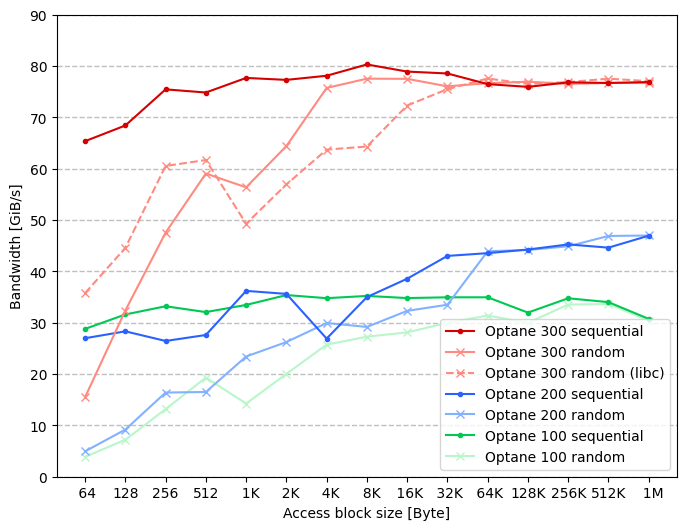

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


,Optane 100 random,Optane 100 sequential,Optane 200 random,Optane 200 sequential,Optane 300 random,Optane 300 sequential
blockSize,,,,,,
64,2.594522,8.344457,3.821872,9.815379,11.270049,11.386552
128,4.987624,10.371421,7.445287,14.722460,18.749892,20.532863
256,10.024866,11.333293,14.011531,14.986178,22.971971,25.216563
512,9.977394,11.403345,13.437177,13.892558,24.186692,25.415045
1024,9.702792,11.507365,12.443069,13.173816,24.528070,25.836094
2048,9.463000,11.550899,11.473061,12.347820,24.703649,25.686861
4096,8.833155,11.514266,9.819301,11.622869,24.656087,25.786644
8192,9.657913,11.542425,10.176946,12.502830,24.566085,25.565717
16384,10.191523,11.545418,11.313746,13.121214,24.773886,25.354389


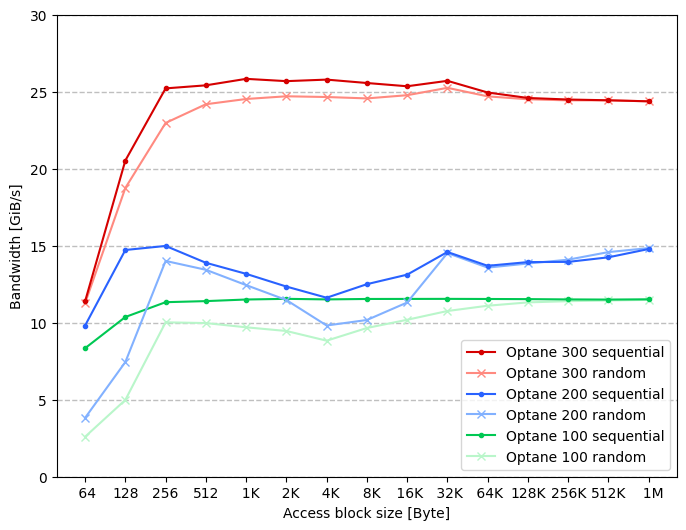

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [11]:
df = df_max

ymax = df.groupby(["accessType"]).max()["byte_per_sec"].apply(lambda x: x / 2**30).apply(lambda x: x + -x % 5).astype('int').to_dict()
ymax["read"] = 90
print(ymax)

platform_list = ["chris80", "chris90", "pegasus"]
# blocksize_list = [64, 256, 4*1024, 128*1024]
blocksize_list = [2**x for x in range(6, 21)]

df = df.loc[df.blockSize.isin(blocksize_list)]

color = {
    "read": [
        "#B9F6CA",
        "#00C853",
        "#82b1ff",
        "#2962ff",
        "#ff8a80", 
        "#ff8a80", 
        "#d50000",
    ],
    "write": [
        "#B9F6CA",
        "#00C853",
        "#82b1ff",
        "#2962ff",
        "#ff8a80", 
        "#d50000",
    ]
}

style = {
    "read": [ "x-", ".-", "x-", ".-", "x--", "x-", ".-" ],
    "write": [ "x-", ".-", "x-", ".-", "x-", ".-" ],
}

for accessType in ["read", "write"]:
    df_plot = pd.concat([
        df_sub.set_index("blockSize")["GiB/s"].rename(f"{idx[0]} {idx[1]}{' (libc)' if idx[2] == 'libc' else ''}")
        for platform in platform_list
        for idx, df_sub in df[(df.accessType == accessType) & (df.platform == platform)].groupby(["device", "accessPattern", "api"])
        if idx[2] == 'libpmem2' or (idx[2] == 'libc' and platform == 'pegasus' and idx[1] == 'random')
    ], axis=1)

    # df_plot.index = df_plot.index.map(lambda x: pretty_fmt(x, suffix=""))

    display(df_plot)

    fig = plt.figure(figsize=(8, 6), dpi=100)
    fig.patch.set_alpha(1)

    ax = df_plot.plot(
        # kind="bar",
        ax=fig.add_subplot(),
        rot=0,
        xlabel="Access block size [Byte]",
        ylabel="Bandwidth [GiB/s]",
        ylim=[0, ymax[accessType]],
        style=style[accessType],
        color=color[accessType],
    )
    
    # ax.set_title(f"Devdax {accessType.capitalize()} {'( nt-store )' if accessType == 'write' else ''}")
    ax.set_xscale("log", base=2)
    ax.set_xticks(df_plot.index, [pretty_fmt(x, suffix="") for x in df_plot.index])
    ax.grid(which = "major", axis = "y", alpha = 0.8, linestyle = "--", linewidth = 1)

    handles, labels = ax.get_legend_handles_labels()# 凡例の情報を取得
    ax.legend(handles=handles[::-1],labels=labels[::-1])# 判例を逆順に表示

    fig.show()
    plt.show()
    save(fig, f"pmembench-comp-devdax-{accessType}")